Step 1: Import Necessary Libraries

In [17]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from kerastuner.tuners import RandomSearch
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import seaborn as sns



Step 2: Load the Dataset

In [18]:
# Load the dataset
nflx_data = pd.read_csv('/kaggle/input/netflix-stock-prediction/NFLX.csv')

# Display basic information
print(nflx_data.info())
print(nflx_data.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1009 entries, 0 to 1008
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1009 non-null   object 
 1   Open       1009 non-null   float64
 2   High       1009 non-null   float64
 3   Low        1009 non-null   float64
 4   Close      1009 non-null   float64
 5   Adj Close  1009 non-null   float64
 6   Volume     1009 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 55.3+ KB
None
         Date        Open        High         Low       Close   Adj Close  \
0  2018-02-05  262.000000  267.899994  250.029999  254.259995  254.259995   
1  2018-02-06  247.699997  266.700012  245.000000  265.720001  265.720001   
2  2018-02-07  266.579987  272.450012  264.329987  264.559998  264.559998   
3  2018-02-08  267.079987  267.619995  250.000000  250.100006  250.100006   
4  2018-02-09  253.850006  255.800003  236.110001  249.470001  249.470001   

   

Data Preprocessing

In [19]:
# Check for missing values in each column
print("Missing Values in Each Column:\n")
print(nflx_data.isnull().sum())

Missing Values in Each Column:

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [20]:
# Keep only the necessary columns for stock price prediction
nflx_data = nflx_data[['Open', 'High', 'Low', 'Close', 'Volume']]

# Display basic information of the cleaned dataset
print("Dataset after dropping unnecessary columns:\n")
print(nflx_data.info())

# Display the first few rows to confirm the structure
print("\nFirst few rows of the dataset:\n")
print(nflx_data.head())


Dataset after dropping unnecessary columns:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1009 entries, 0 to 1008
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1009 non-null   float64
 1   High    1009 non-null   float64
 2   Low     1009 non-null   float64
 3   Close   1009 non-null   float64
 4   Volume  1009 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 39.5 KB
None

First few rows of the dataset:

         Open        High         Low       Close    Volume
0  262.000000  267.899994  250.029999  254.259995  11896100
1  247.699997  266.700012  245.000000  265.720001  12595800
2  266.579987  272.450012  264.329987  264.559998   8981500
3  267.079987  267.619995  250.000000  250.100006   9306700
4  253.850006  255.800003  236.110001  249.470001  16906900


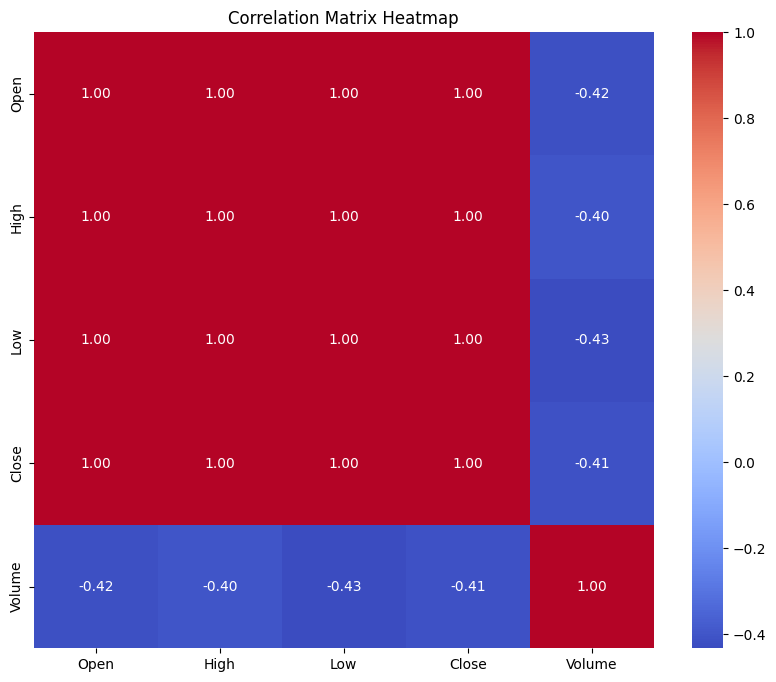

In [21]:
import matplotlib.pyplot as plt
# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(nflx_data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()


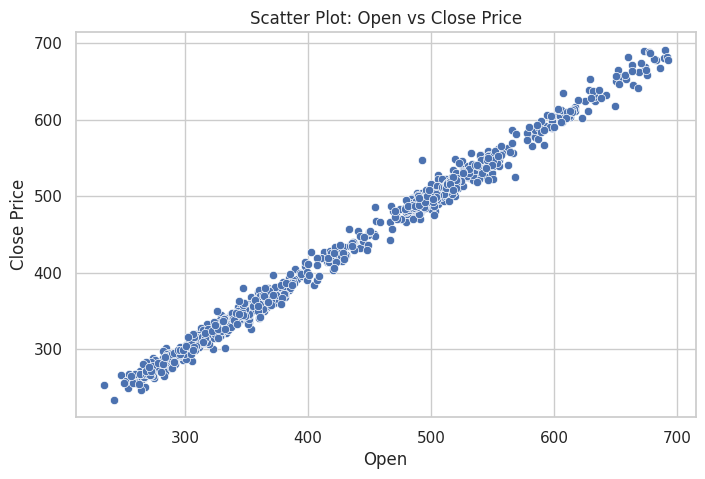

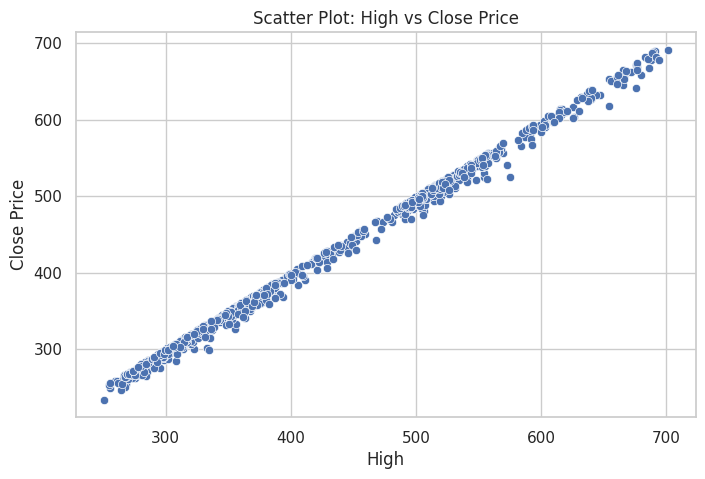

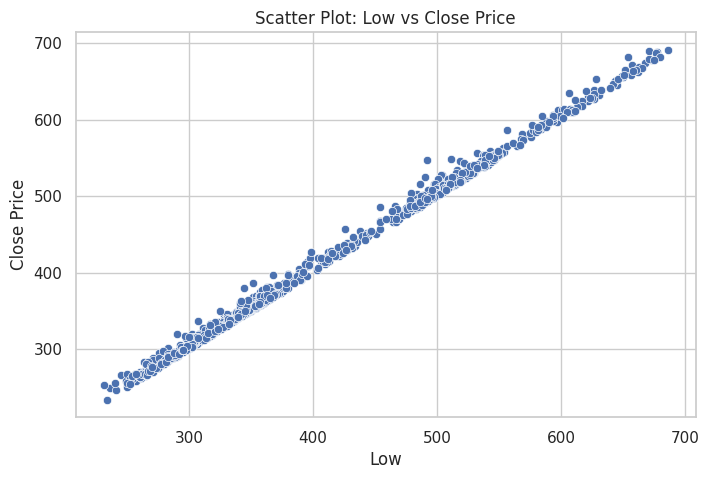

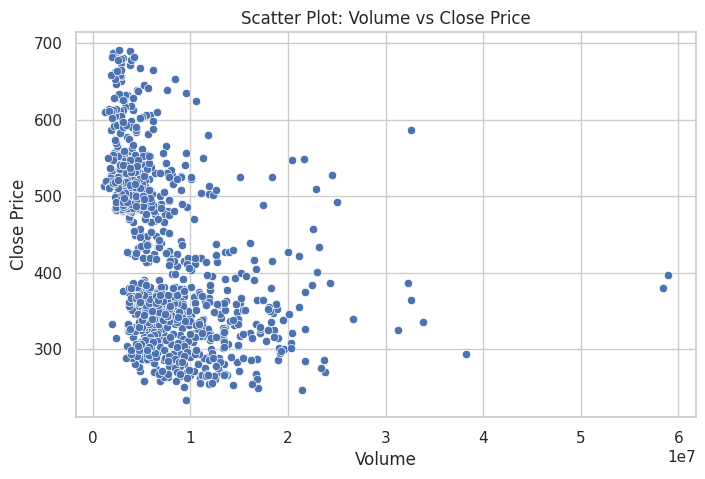

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

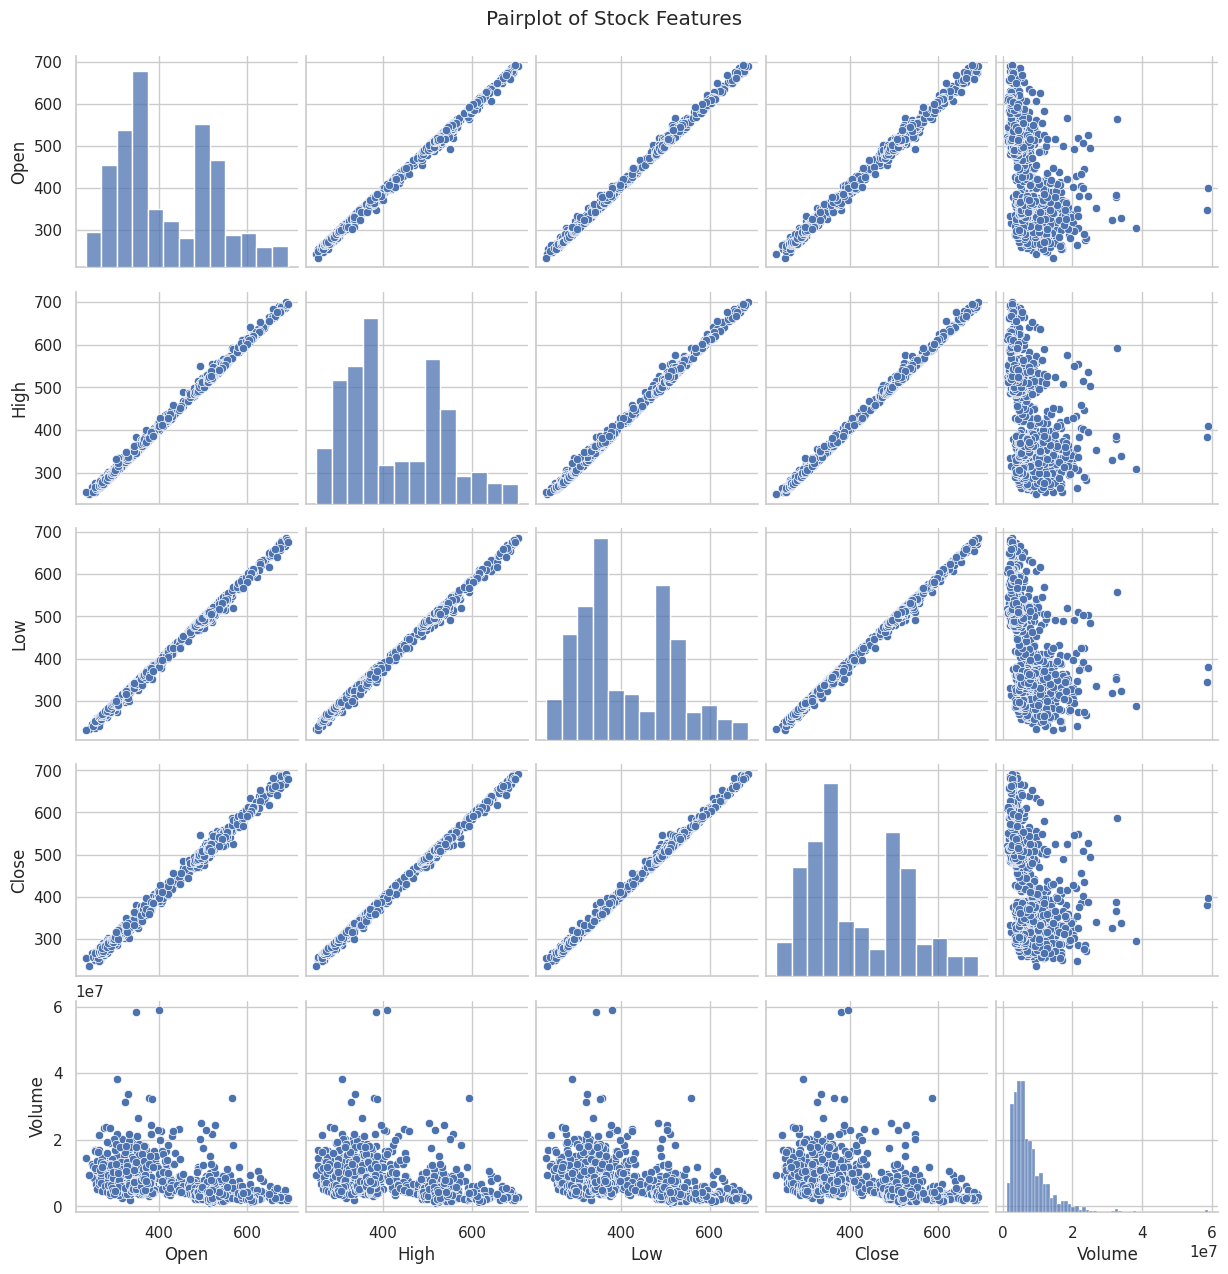

In [22]:
# Import necessary libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Set a style for the plots
sns.set(style="whitegrid")

# List of important features to visualize against the 'Close' price
important_features = ['Open', 'High', 'Low', 'Volume']

# Scatter plots to show relationships between each feature and 'Close' price
for feature in important_features:
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=nflx_data[feature], y=nflx_data['Close'])
    plt.title(f'Scatter Plot: {feature} vs Close Price')
    plt.xlabel(feature)
    plt.ylabel('Close Price')
    plt.grid(True)
    plt.show()

# Optional: Pairplot to visualize relationships between all numerical features
sns.pairplot(nflx_data)
plt.suptitle("Pairplot of Stock Features", y=1.02)
plt.show()


In [23]:
# Define 'Open' as the feature and 'Close' as the target
X = nflx_data[['Open']]  # Powerful feature selected
y = nflx_data['Close']    # Target variable


In [24]:
from sklearn.preprocessing import MinMaxScaler

# Scale the features for better model performance
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_X = scaler.fit_transform(X)


In [25]:
import numpy as np

# Function to create time-series sequences for LSTM
def create_sequences(data, seq_length):
    X_seq, y_seq = [], []
    for i in range(seq_length, len(data)):
        X_seq.append(data[i - seq_length:i])  # Previous 'seq_length' days
        y_seq.append(data[i, 0])             # Predicting the next 'Close' price
    return np.array(X_seq), np.array(y_seq)

# Sequence length for LSTM (e.g., 60 previous days)
sequence_length = 60
X_seq, y_seq = create_sequences(scaled_X, sequence_length)


In [32]:
# Split data into training and testing sets (80% training, 20% testing)
split = int(0.7 * len(X_seq))
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]

print("Training shape:", X_train.shape)
print("Testing shape:", X_test.shape)


Training shape: (664, 60, 1)
Testing shape: (285, 60, 1)


In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from kerastuner.tuners import RandomSearch

# Define LSTM model for hyperparameter tuning
def build_lstm_model(hp):
    model = Sequential()
    
    # First LSTM Layer
    model.add(LSTM(units=hp.Int('units_1', min_value=50, max_value=200, step=50),
                   return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)))
    
    # Second LSTM Layer
    model.add(LSTM(units=hp.Int('units_2', min_value=50, max_value=200, step=50)))
    model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)))
    
    # Output Layer
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    return model


In [34]:
from tensorflow.keras.callbacks import EarlyStopping

# Set up Random Search for hyperparameter tuning
tuner = RandomSearch(
    build_lstm_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=2,
    directory='lstm_tuning',
    project_name='Stock_Prediction'
)

# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5)

# Perform hyperparameter search
tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[early_stop])

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]


Reloading Tuner from lstm_tuning/Stock_Prediction/tuner0.json


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [35]:
# Train the optimized model
history = best_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)


Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 189ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - loss: 8.2982e-04 - val_loss: 0.0011
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step - loss: 5.4886e-04 - val_loss: 9.5073e-04
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step - loss: 5.9912e-04 - val_loss: 0.0011
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step - loss: 6.1766e-04 - val_loss: 0.0012
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - loss: 6.3364e-04 - val_loss: 0.0012
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step - loss: 7.0733e-04 - val_loss: 0.0010
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 165ms/step - loss: 7.1126e-04 - val_loss: 9.9740e-04
Epoch 9/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 174ms/step - loss: 4.9095e-04 - val_loss: 0.0012
Epoch 10/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 178ms/step - loss: 6.0598e-04 - val_loss: 0.0012
Epoch 11/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - loss: 5.9707e-04 - val_loss: 0.0011
Epoc

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step


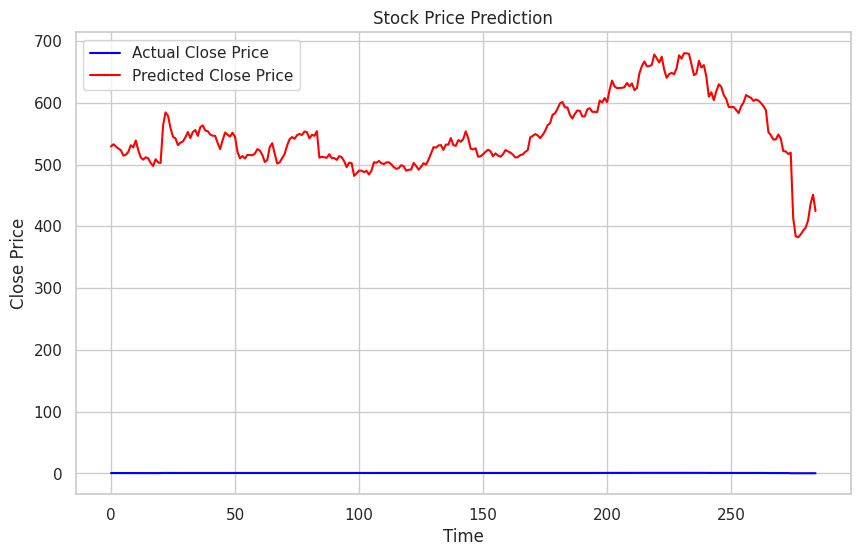

In [36]:
# Predict stock prices
predictions = best_model.predict(X_test)
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))

# Plot predictions vs actual values
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test, color='blue', label='Actual Close Price')
plt.plot(predictions, color='red', label='Predicted Close Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()


In [39]:
# Compress all output files into a ZIP file
!zip -r output_files.zip /kaggle/working/


updating: kaggle/working/ (stored 0%)
updating: kaggle/working/lstm_tuning/ (stored 0%)
updating: kaggle/working/lstm_tuning/Stock_Prediction/ (stored 0%)
updating: kaggle/working/lstm_tuning/Stock_Prediction/trial_09/ (stored 0%)
updating: kaggle/working/lstm_tuning/Stock_Prediction/trial_09/trial.json (deflated 68%)
updating: kaggle/working/lstm_tuning/Stock_Prediction/trial_09/checkpoint.weights.h5 (deflated 8%)
updating: kaggle/working/lstm_tuning/Stock_Prediction/trial_09/build_config.json (stored 0%)
updating: kaggle/working/lstm_tuning/Stock_Prediction/trial_01/ (stored 0%)
updating: kaggle/working/lstm_tuning/Stock_Prediction/trial_01/trial.json (deflated 68%)
updating: kaggle/working/lstm_tuning/Stock_Prediction/trial_01/checkpoint.weights.h5 (deflated 7%)
updating: kaggle/working/lstm_tuning/Stock_Prediction/trial_01/build_config.json (stored 0%)
updating: kaggle/working/lstm_tuning/Stock_Prediction/trial_02/ (stored 0%)
updating: kaggle/working/lstm_tuning/Stock_Prediction/t

In [40]:
# Create a download link for the ZIP file
from IPython.display import FileLink

FileLink('/kaggle/working/output_files.zip')


/kaggle/working/output_files.zip